<a href="https://colab.research.google.com/github/YUCAVALCANTE/ML_Studies/blob/main/Clusteriza%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

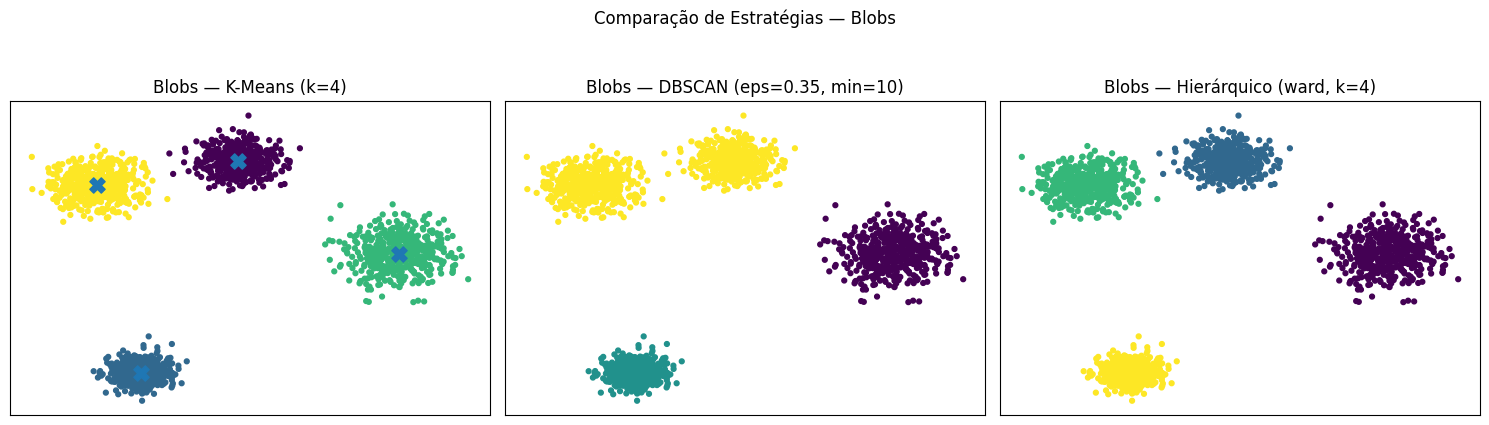

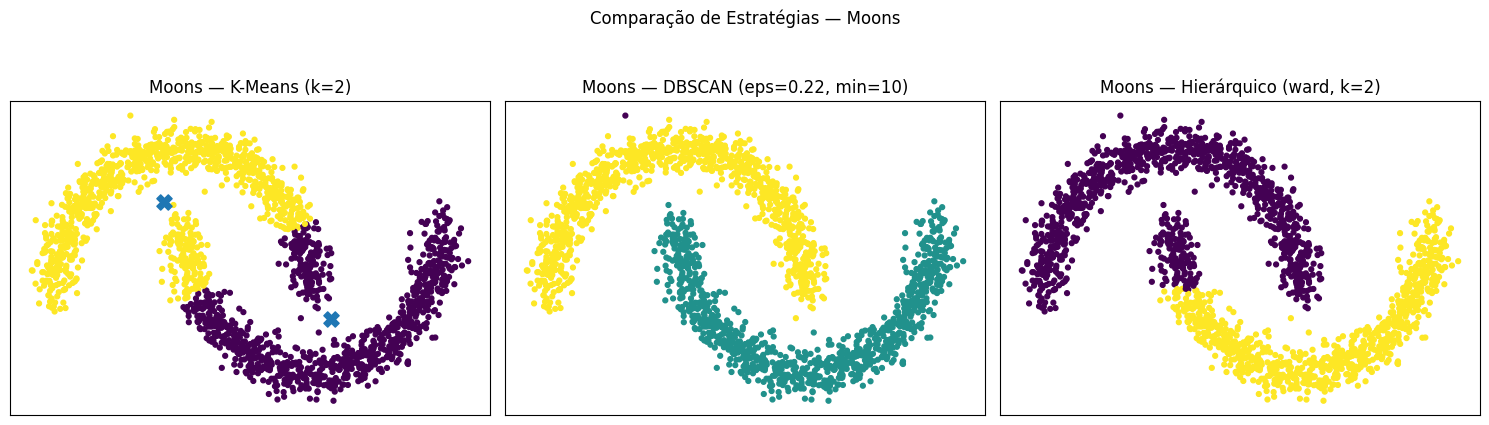

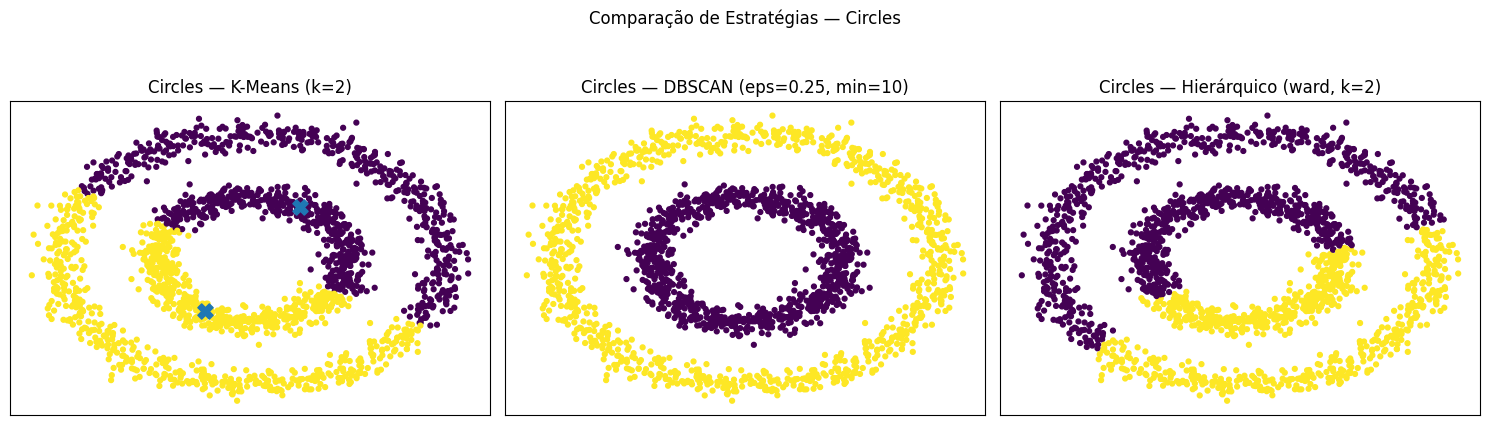

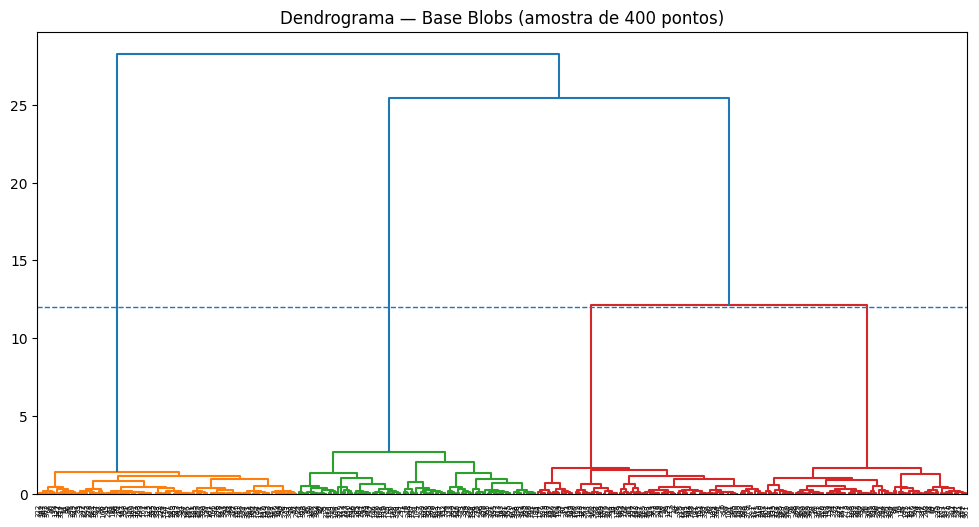

In [1]:
# O que este bloco faz:
# 1) cria 3 bases sintéticas com geometrias diferentes (blobs, moons, circles) + ruído
# 2) padroniza os dados (importante para métodos baseados em distância)
# 3) roda 3 estratégias de clusterização em cada base:
#    - K-Means (partição)
#    - DBSCAN (densidade)
#    - Hierárquico Aglomerativo (hierárquico)
# 4) plota comparações lado a lado (mesma base, métodos diferentes)
# 5) gera dendrograma para a base de blobs (estrutura hierárquica)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

import scipy.cluster.hierarchy as shc


# -----------------------------
# 0) Funções auxiliares
# -----------------------------
def plot_clusters(ax, X, labels, title):
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=12)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

def run_kmeans(X, k=4, seed=42):
    model = KMeans(n_clusters=k, random_state=seed, n_init=10)
    labels = model.fit_predict(X)
    return labels, model.cluster_centers_

def run_dbscan(X, eps=0.25, min_samples=10):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X)
    return labels

def run_agglomerative(X, n_clusters=4, linkage="ward"):
    # ward exige métrica euclidiana
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = model.fit_predict(X)
    return labels


# -----------------------------
# 1) Criando bases sintéticas robustas
# -----------------------------
rng = 42
np.random.seed(rng)

# Base A: blobs (bom para K-Means)
X_blobs, _ = make_blobs(
    n_samples=2000,
    centers=4,
    cluster_std=[0.9, 1.2, 0.7, 1.0],
    random_state=rng
)

# Base B: moons (forma não convexa)
X_moons, _ = make_moons(
    n_samples=2000,
    noise=0.08,
    random_state=rng
)

# Base C: circles (anéis) + ruído
X_circles, _ = make_circles(
    n_samples=2000,
    noise=0.06,
    factor=0.5,
    random_state=rng
)

# Padronização (importante para distância/DBSCAN)
scaler = StandardScaler()
X_blobs_s = scaler.fit_transform(X_blobs)
X_moons_s = scaler.fit_transform(X_moons)
X_circles_s = scaler.fit_transform(X_circles)


# -----------------------------
# 2) Rodando modelos em cada base
# -----------------------------
def compare_methods(X, base_name, k=4, db_eps=0.25, db_min=10):
    # K-Means
    km_labels, km_centers = run_kmeans(X, k=k, seed=rng)

    # DBSCAN
    db_labels = run_dbscan(X, eps=db_eps, min_samples=db_min)

    # Hierárquico
    ag_labels = run_agglomerative(X, n_clusters=k, linkage="ward")

    # Plot lado a lado
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    plot_clusters(axes[0], X, km_labels, f"{base_name} — K-Means (k={k})")

    # marcar centros do K-Means
    axes[0].scatter(km_centers[:, 0], km_centers[:, 1], s=120, marker="X")

    plot_clusters(axes[1], X, db_labels, f"{base_name} — DBSCAN (eps={db_eps}, min={db_min})")
    plot_clusters(axes[2], X, ag_labels, f"{base_name} — Hierárquico (ward, k={k})")

    fig.suptitle(f"Comparação de Estratégias — {base_name}", y=1.05)
    plt.tight_layout()
    plt.show()


# Blobs: DBSCAN eps um pouco menor costuma funcionar bem
compare_methods(X_blobs_s, "Blobs", k=4, db_eps=0.35, db_min=10)

# Moons: DBSCAN tende a brilhar, K-Means tende a forçar corte
compare_methods(X_moons_s, "Moons", k=2, db_eps=0.22, db_min=10)

# Circles: DBSCAN tende a capturar os anéis
compare_methods(X_circles_s, "Circles", k=2, db_eps=0.25, db_min=10)


# -----------------------------
# 3) Dendrograma (hierárquico)
# -----------------------------
idx = np.random.choice(len(X_blobs_s), size=400, replace=False)
X_sample = X_blobs_s[idx]

plt.figure(figsize=(12, 6))
plt.title("Dendrograma — Base Blobs (amostra de 400 pontos)")
dend = shc.dendrogram(shc.linkage(X_sample, method="ward"))

# linha de corte ilustrativa (ajuste conforme necessário)
plt.axhline(y=12, linestyle="--", linewidth=1)
plt.show()
